# 2 Time series forecasting with sktime
Estimated time: 20 min

## Introduction

What is a time series and what can we forecast?

![](../images/ts_quiz.png)

## Agenda

- Quickstart
- Univariate forecasting
    - With statistical models
    - With machine learning models
    - Model evaluation and selection
- Univariate forecasting with exogenous data
- Multivariate forecasting
- Probabilistic forecasting
- Hierarchical forecasting

## Quickstart

* typical business use case :-)
* here's some monthly historic sales data

In [1]:
import warnings

warnings.filterwarnings("ignore")

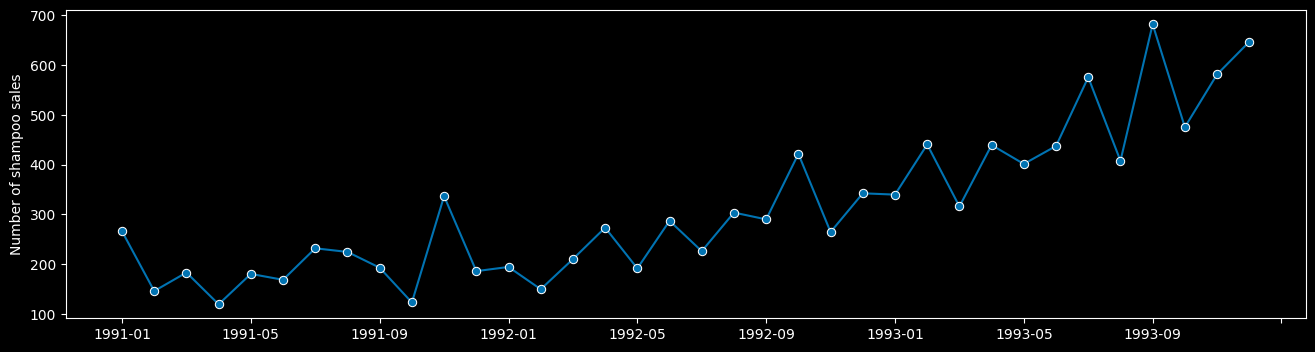

In [2]:
from sktime.datasets import load_shampoo_sales
from sktime.utils.plotting import plot_series

y = load_shampoo_sales()

fig, ax = plot_series(y)

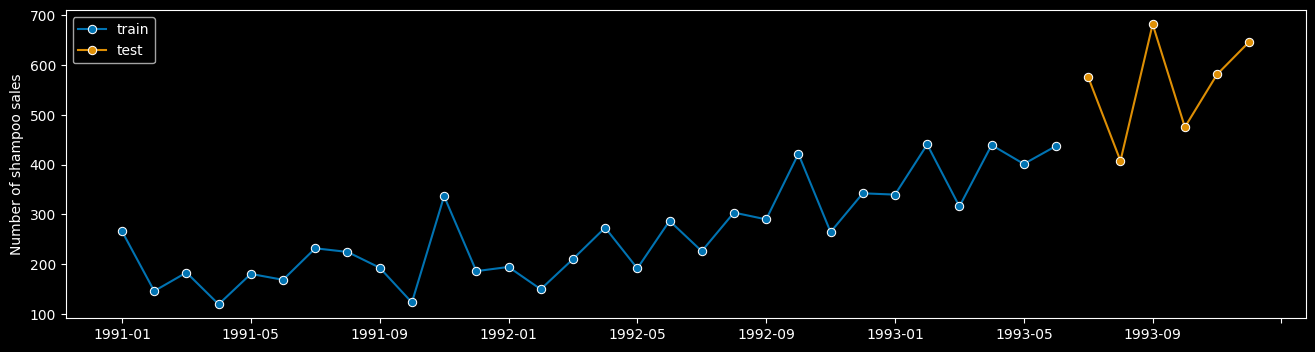

In [3]:
from sktime.forecasting.model_selection import temporal_train_test_split

y_train, y_test = temporal_train_test_split(y=y, test_size=6)
fig, ax = plot_series(y_train, y_test, labels=["train", "test"])

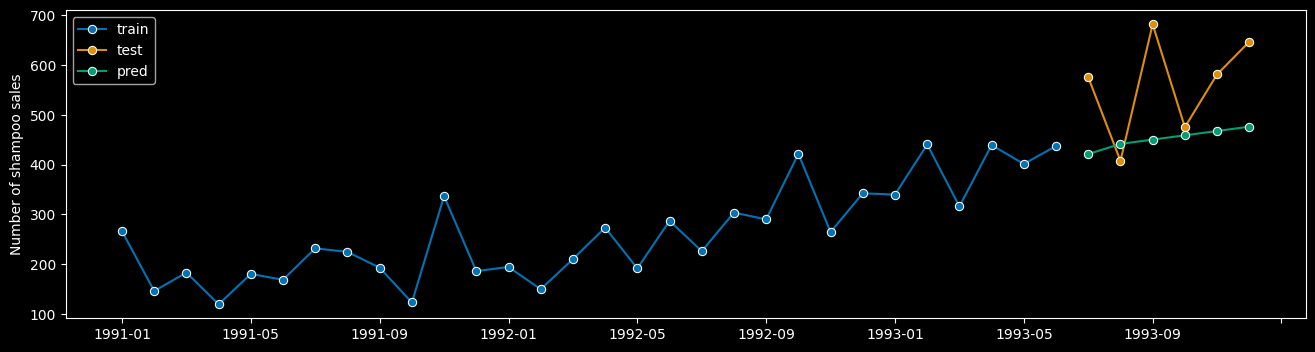

In [4]:
from sktime.forecasting.arima import AutoARIMA

# 1) Define the model
forecaster = AutoARIMA(suppress_warnings=True)

# 2) Fit on train data
forecaster.fit(y_train)

# 3) Use fitted model to predict for a certain forecast horizon (fh)
fh = [1, 2, 3, 4, 5, 6]  # Relative to y_train
y_pred = forecaster.predict(fh)

fig, ax = plot_series(y_train, y_test, y_pred, labels=["train", "test", "pred"])

* scoring using `sktime` performance metrics
* requires forecasts & true values as `sktime` compatible time series

In [5]:
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError

smape = MeanAbsolutePercentageError(symmetric=True)

print(f"AutoARIMA - sMAPE error: {smape(y_test, y_pred):.1%}")

AutoARIMA - sMAPE error: 22.6%


Notes:

* MAPE just for illustration - not always best choice
* for robust evaluation & comparison, use backtesting (not single train/test split)

## 2.1 Univariate forecasting

showcase common approaches for forecasting univariate time series in `sktime`:
- Classical statistical models (e.g., econometric, ARIMA, etc)
- Machine learning models (e.g., direct/recursive reduction)

Recommendation: try simple models and naive baselines first!

### Classical forecasting method example: `AutoETS`

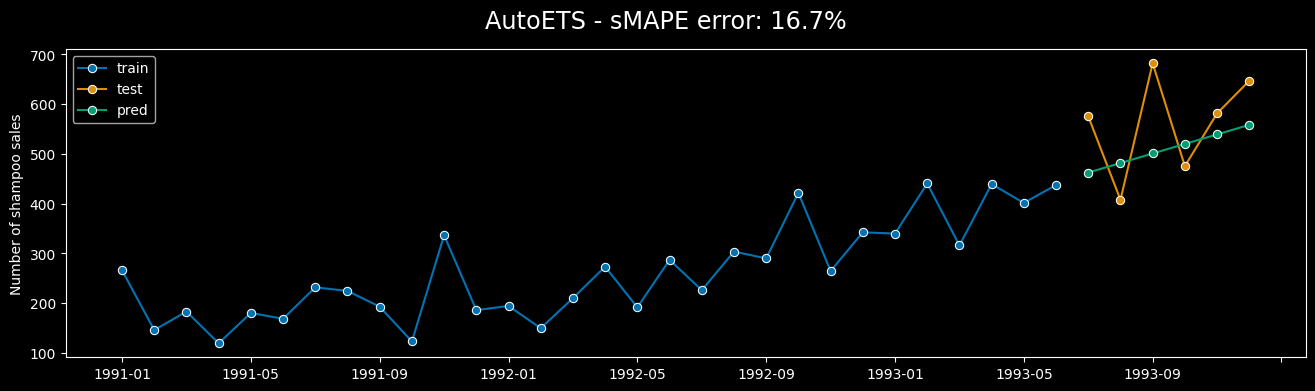

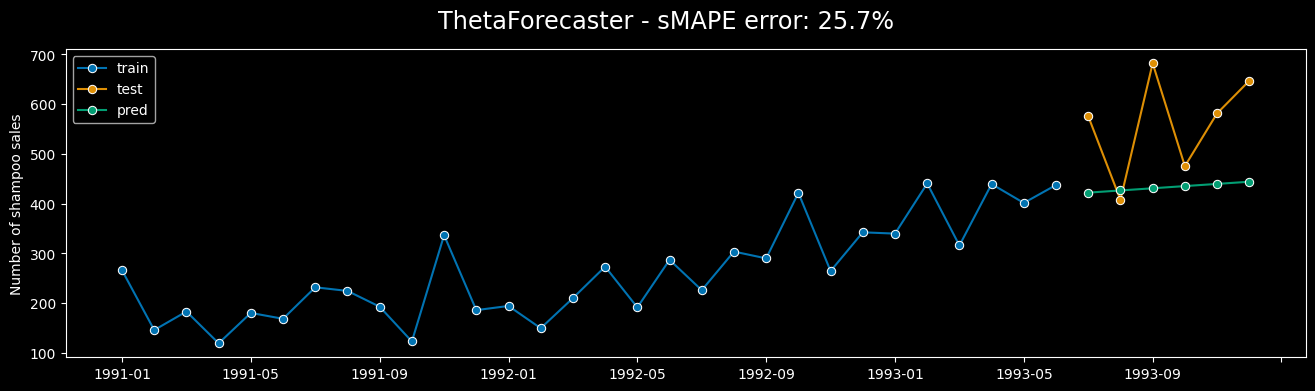

In [6]:
from sktime.forecasting.ets import AutoETS
from sktime.forecasting.theta import ThetaForecaster

forecasters = [AutoETS(auto=True), ThetaForecaster()]

for forecaster in forecasters:
    y_pred = forecaster.fit_predict(y=y_train, fh=fh)
    title = (
        f"{str(forecaster).split('(')[0]} - sMAPE error: {smape(y_test, y_pred):.1%}"
    )
    fig, ax = plot_series(
        y_train, y_test, y_pred, labels=["train", "test", "pred"], title=title
    )

Check out all other sktime forecasting algorithms [in the documentation](https://www.sktime.net/en/latest/api_reference/forecasting.html) or by running the code below:

In [7]:
from sktime.registry import all_estimators

all_estimators("forecaster", as_dataframe=True, suppress_import_stdout=False)

,name,object
0,ARCH,<class 'sktime.forecasting.arch._uarch.ARCH'>
1,ARDL,<class 'sktime.forecasting.ardl.ARDL'>
2,ARIMA,<class 'sktime.forecasting.arima.ARIMA'>
3,AutoARIMA,<class 'sktime.forecasting.arima.AutoARIMA'>
4,AutoETS,<class 'sktime.forecasting.ets.AutoETS'>
...,...,...
65,UpdateRefitsEvery,<class 'sktime.forecasting.stream._update.Upda...
66,VAR,<class 'sktime.forecasting.var.VAR'>
67,VARMAX,<class 'sktime.forecasting.varmax.VARMAX'>
68,VECM,<class 'sktime.forecasting.vecm.VECM'>


### Forecasting with ML algorithms (reduction)

- uses sklearn regressor on tabulated data to forecast
- plug & play any sklearn compatible regressor, e.g., lightgbm or xgboost
- important: forecasting != regression

Estimator does this internally:

![](./img/forecasting-to-regression-reduction.png)

in unified forecasting interface! No need to handle `sklearn` directly

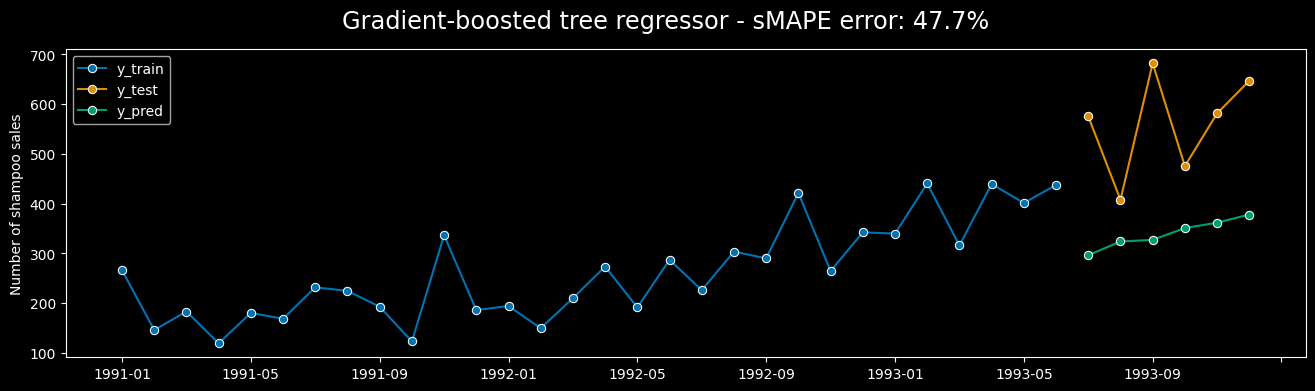

In [8]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sktime.forecasting.compose import make_reduction

# Can be swapped with XBGoost, LightGBM, CatBoost, etc.
regressor = HistGradientBoostingRegressor()

# Create a forecaster from the tabular regressor by wrapping it in `make_reduction`
forecaster = make_reduction(regressor, strategy="direct", window_length=16)

y_pred = forecaster.fit_predict(y=y_train, fh=fh)
title = f"Gradient-boosted tree regressor - sMAPE error: {smape(y_test, y_pred):.1%}"
fig, ax = plot_series(
    y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"], title=title
)

... this is bad! Why?

Subtle:

- Gradient boosting trees cannot "extrapolate"
- only forecast well within their observed range

Solution: make (more) stationary by differencing

easy to do in `sktime`: transformers (= transformation estimators)

(note: wider concept than deep learn transformers, includes simple trafos too)

Let's see how to use the `Differencer` transformer:

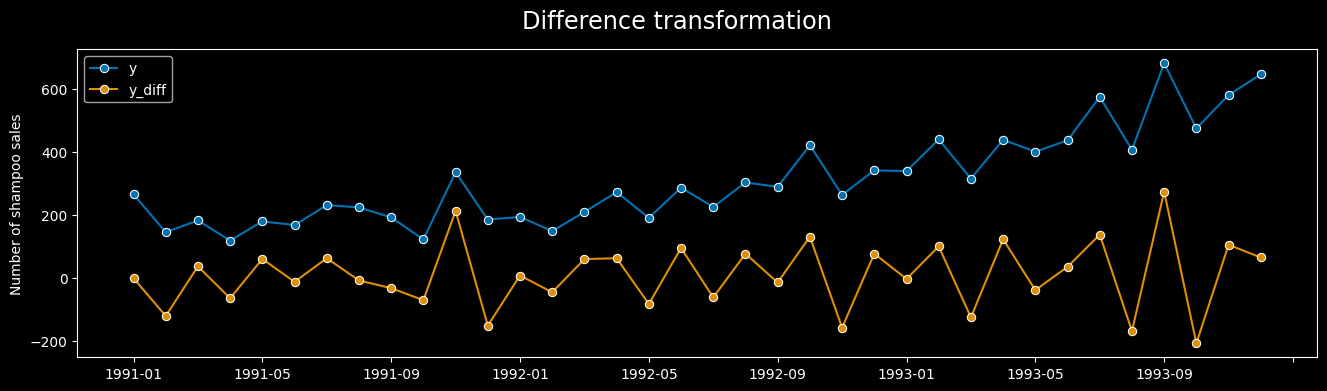

In [9]:
from sktime.transformations.series.difference import Differencer

transformer = Differencer(lags=1)
y_transform = transformer.fit_transform(y)
fig, ax = plot_series(
    y, y_transform, labels=["y", "y_diff"], title="Difference transformation"
)

Transformers composable with forecasters, plug together to forecaster!

here: plug `Differencer` into tree-based reduction forecaster, via `*` dunder:

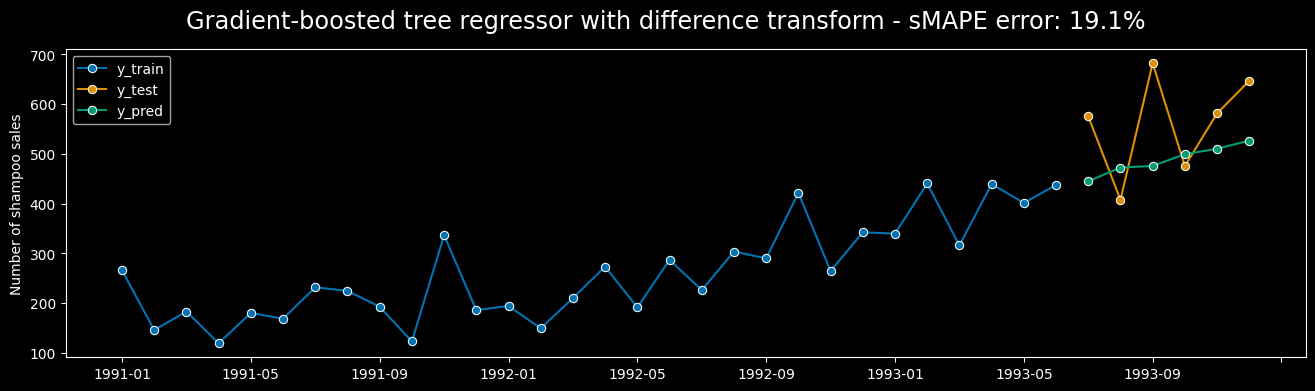

In [10]:
regressor = HistGradientBoostingRegressor()
forecaster = make_reduction(regressor, strategy="direct", window_length=16)
forecaster_with_differencer = Differencer(lags=1) * forecaster

y_pred = forecaster_with_differencer.fit_predict(y=y_train, fh=fh)
title = f"Gradient-boosted tree regressor with difference transform - sMAPE error: {smape(y_test, y_pred):.1%}"
fig, ax = plot_series(
    y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"], title=title
)

More on transformers and composition later!

## 2.2 Univariate forecasting with exogenous data

- exogeneous data = other related time series that can improve prediction
- Example: information about promotions when forecasting sales (promotions drive sales)


We start by loading the same sales data we have been working on before.

In [11]:
from sktime.datasets import load_shampoo_sales

y = load_shampoo_sales()

Let's use the sales data, noise and some simple transformations to create *fake* promotion

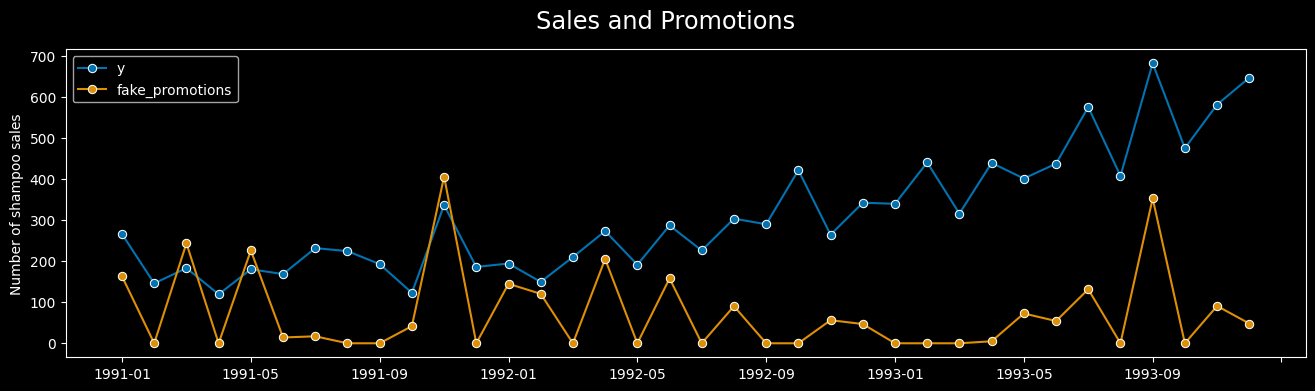

In [12]:
import numpy as np
from sktime.utils.plotting import plot_series
from sktime.transformations.series.difference import Differencer

# Use a differencer, clipping and some noise to generate fake promotional data
transformer = Differencer(lags=1)
y_transform = transformer.fit_transform(y)
noise = np.random.RandomState(seed=93).normal(0, 100, np.shape(y))
X_promo = (y_transform + noise).clip(lower=0)

fig, ax = plot_series(
    y, X_promo, labels=["y", "fake_promotions"], title="Sales and Promotions"
)

We can split both the target time series (y: sales) and the exogenous time series (X: promotions) with the `temporal_train_test_split` we have used before.

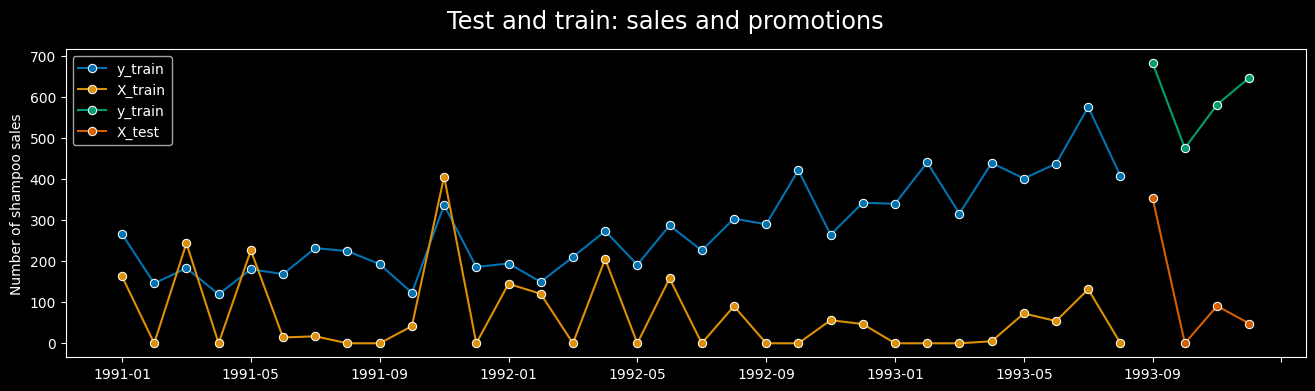

In [13]:
from sktime.forecasting.model_selection import temporal_train_test_split

fh = [1, 2, 3, 4]
y_train, y_test, X_train, X_test = temporal_train_test_split(
    y=y, X=X_promo, test_size=len(fh)
)

fig, ax = plot_series(
    y_train,
    X_train,
    y_test,
    X_test,
    labels=["y_train", "X_train", "y_train", "X_test"],
    title="Test and train: sales and promotions",
)

Now we can forecast y (sales) also using the known values of future X (promotions) by passing the future X data in the predict step.

In [14]:
from sktime.forecasting.arima import AutoARIMA

forecaster = AutoARIMA(suppress_warnings=True)

# Use train data in fit
forecaster.fit(y=y_train, X=X_train, fh=fh)

# Note how the "future" data of X is passed in the predict step
y_pred = forecaster.predict(X=X_test)

Let's see how the prediction looks like when adding promotional data.

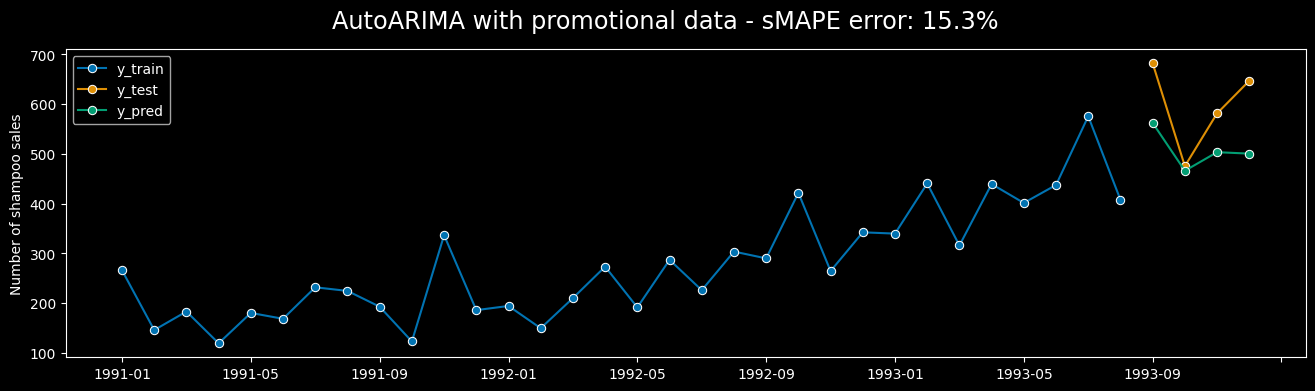

In [15]:
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError

smape = MeanAbsolutePercentageError(symmetric=True)

title = f"AutoARIMA with promotional data - sMAPE error: {smape(y_test, y_pred):.1%}"
fig, ax = plot_series(
    y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"], title=title
)

Note: as we created the promotions from the sales data, the performance upflift is over-optimistic (data leakage).

But what if don't have future promotional data?

If we believe that we can forecast `X` (promotions) independently of `y` (sales) we can use these predictions of `X` to inform the predictions of `y`.

Here, we decide to use a different model for `X` than for `y`:
- y (sales): AutoARIMA
- X (promotion): Croston - due to intermittency


In [16]:
from sktime.forecasting.compose import ForecastX
from sktime.forecasting.croston import Croston

forecaster_X = ForecastX(
    forecaster_y=AutoARIMA(suppress_warnings=True),
    forecaster_X=Croston(),
)
forecaster_X.fit(y=y, X=X_promo, fh=fh)

ForecastX(forecaster_X=Croston(),
          forecaster_y=AutoARIMA(suppress_warnings=True))

After fitting on both `X` and `y` we can creat predictions of `y` directly. Under the hood `sktime` is forecasting `X` with the `Croston()` model and using it in the prediction step of `y`.

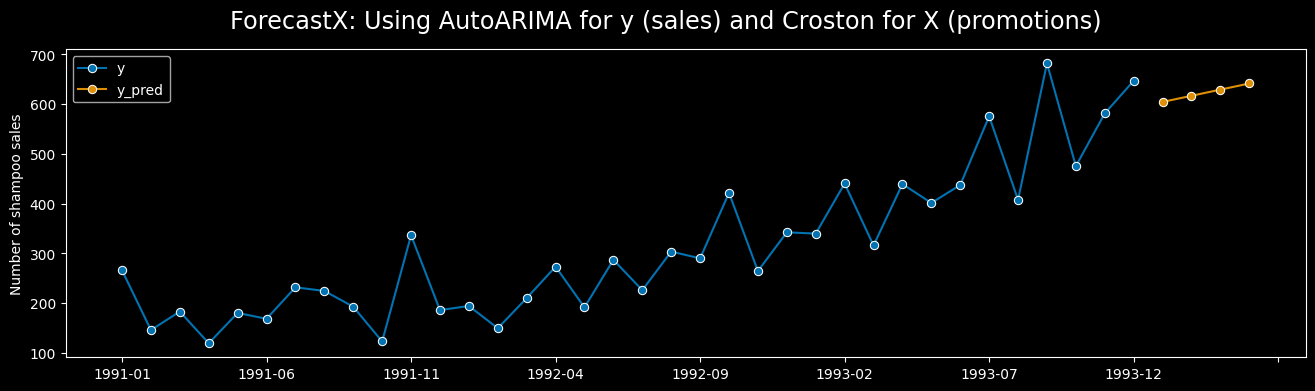

In [17]:
# Now in the `predict` step we don't need to pass X
y_pred = forecaster_X.predict(fh=fh)

title = "ForecastX: Using AutoARIMA for y (sales) and Croston for X (promotions)"
fig, ax = plot_series(y, y_pred, labels=["y", "y_pred"], title=title)

- Sometimes, the focus is not on a single univariate time series, but rather on forecasting a group of time series that represent different aspects of a single entity.
- Example: forecasting multiple macroeconomic indicators that collectively measure "the economy".

Let's explore how `sktime` enables multivariate forecasting for this use-case.

## 2.3 Multivariate forecasting

We begin by loading the historical data of a couple of macro indicators, which are reported yearly.

In [18]:
from sktime.datasets import load_longley

_, y = load_longley()

y = y.drop(columns=["UNEMP", "ARMED", "POP"])

y

,GNPDEFL,GNP
Period,,
1947,83.0,234289.0
1948,88.5,259426.0
1949,88.2,258054.0
1950,89.5,284599.0
1951,96.2,328975.0
1952,98.1,346999.0
1953,99.0,365385.0
1954,100.0,363112.0
1955,101.2,397469.0


In `sktime` some forecasters such as `VAR()` are purely mutlivariate. Let's use it to make some predictions:

In [19]:
from sktime.forecasting.var import VAR

forecaster = VAR()
forecaster.fit(y, fh=[1, 2, 3])

y_pred = forecaster.predict()
y_pred

,GNPDEFL,GNP
Period,,
1963,121.688295,578514.398653
1964,124.353664,601873.015890
1965,126.847886,625411.588754


We can inspects the tags of the `VAR()` forecasteer through to `get_tags` to check its multivariate nature.

In [20]:
forecaster.get_tags()

{'python_dependencies_alias': {'scikit-learn': 'sklearn'},
 'object_type': 'forecaster',
 'scitype:y': 'multivariate',
 'ignores-exogeneous-X': True,
 'capability:insample': True,
 'capability:pred_int': True,
 'capability:pred_int:insample': False,
 'handles-missing-data': False,
 'y_inner_mtype': 'pd.DataFrame',
 'X_inner_mtype': 'pd.DataFrame',
 'requires-fh-in-fit': False,
 'X-y-must-have-same-index': True,
 'enforce_index_type': None,
 'fit_is_empty': False,
 'python_version': None,
 'python_dependencies': 'statsmodels',
 'univariate-only': False}

But we can also use univariate forecasters to forecast multiple time series! Let's see how this is done using `ARIMA` which is a purely univariate model.

In [21]:
from sktime.datasets import load_longley
from sktime.forecasting.arima import ARIMA

_, y = load_longley()

y = y.drop(columns=["UNEMP", "ARMED", "POP"])

forecaster = ARIMA()
forecaster.fit(y, fh=[1, 2, 3])

forecaster.forecasters_

,GNPDEFL,GNP
forecasters,ARIMA(),ARIMA()


As we can see `sktime` fits one single `ARIMA()` model per time series.

We can also check the nature of the `ARIMA()` model using the `get_tags`.

In [22]:
forecaster.get_tags()

{'python_dependencies_alias': {'scikit-learn': 'sklearn'},
 'object_type': 'forecaster',
 'scitype:y': 'univariate',
 'ignores-exogeneous-X': False,
 'capability:insample': True,
 'capability:pred_int': True,
 'capability:pred_int:insample': True,
 'handles-missing-data': True,
 'y_inner_mtype': 'pd.Series',
 'X_inner_mtype': 'pd.DataFrame',
 'requires-fh-in-fit': False,
 'X-y-must-have-same-index': True,
 'enforce_index_type': None,
 'fit_is_empty': False,
 'python_version': None,
 'python_dependencies': 'pmdarima'}

- Point predictions may not suffice in many forecasting scenarios.
- Even with the best models, forecasts inherently contain some level of uncertainty.
- This uncertainty can be expressed, by for example, providing prediction intervals.

`sktime` allows for straightforward generation of prediction intervals to capture forecast uncertainty.

## 2.4 Probabilistic forecasting

In [23]:
from sktime.datasets import load_shampoo_sales

y = load_shampoo_sales()

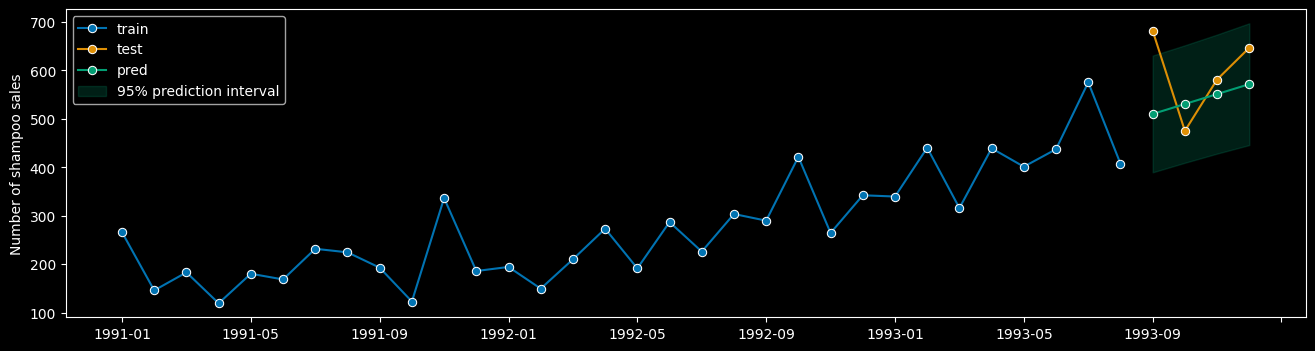

In [24]:
from sktime.forecasting.ets import AutoETS

# 1) Define the model
forecaster = AutoETS(auto=True)

# 2) Fit on train data
forecaster.fit(y_train)

# 3) Use fitted model to predict for a certain forecast horizon (fh)
fh = [1, 2, 3, 4]
y_pred = forecaster.predict(fh)

# 4) Call a probabilistic method after or in place of step 3
y_pred_int = forecaster.predict_interval(coverage=0.95)

fig, ax = plot_series(
    y_train, y_test, y_pred, labels=["train", "test", "pred"], pred_interval=y_pred_int
)

The following methods are possibly available for probabilistic forecasts:

- `predict_interval` produces interval forecasts. Additionally to any `predict` arguments, an argument `coverage` (nominal interval coverage) must be provided.
- `predict_quantiles` produces quantile forecasts. Additionally to any `predict` arguments, an argument `alpha` (quantile values) must be provided.
- `predict_var` produces variance forecasts. This has same arguments as `predict`.
- `predict_proba` produces full distributional forecasts. This has same arguments as `predict`.

| Name | param | prediction/estimate of | `sktime` |
| ---- | ----- | ---------------------- | -------- |
| point forecast | | conditional expectation $\mathbb{E}[y'\|y]$ | `predict` |
| variance forecast | | conditional variance $Var[y'\|y]$ | `predict_var` |
| quantile forecast | $\alpha\in (0,1)$ | $\alpha$-quantile of $y'\|y$ | `predict_quantiles` |
| interval forecast | $c\in (0,1)$| $[a,b]$ s.t. $P(a\le y' \le b\| y) = c$ | `predict_interval` |
| distribution forecast | | the law/distribution of $y'\|y$ | `predict_proba` |

We can check which estimators can perform probabiilistic forecasting by checking `all_stimators`.

In [25]:
from sktime.registry import all_estimators

all_estimators(
    "forecaster",
    filter_tags={"capability:pred_int": True},
    as_dataframe=True,
    suppress_import_stdout=False,
)

,name,object
0,ARCH,<class 'sktime.forecasting.arch._uarch.ARCH'>
1,ARIMA,<class 'sktime.forecasting.arima.ARIMA'>
2,AutoARIMA,<class 'sktime.forecasting.arima.AutoARIMA'>
3,AutoETS,<class 'sktime.forecasting.ets.AutoETS'>
4,BATS,<class 'sktime.forecasting.bats.BATS'>
5,BaggingForecaster,<class 'sktime.forecasting.compose._bagging.Ba...
6,ColumnEnsembleForecaster,<class 'sktime.forecasting.compose._column_ens...
7,ConformalIntervals,<class 'sktime.forecasting.conformal.Conformal...
8,DynamicFactor,<class 'sktime.forecasting.dynamic_factor.Dyna...
9,FhPlexForecaster,<class 'sktime.forecasting.compose._fhplex.FhP...


Note:  estimators that have the `pred_int` tag always have all the probabilistic methods available. So estimators either have all of them or none.

Now let's look at the difference probabilistic methods and their different outputs.

In [26]:
forecaster.predict_interval(coverage=0.95)

Number of shampoo sales            
                           0.95            
                          lower       upper
1993-09              389.650236  630.743131
1993-10              409.429859  651.972595
1993-11              428.319020  674.092522
1993-12              446.003062  697.417568

In [27]:
forecaster.predict_quantiles(alpha=[0.275, 0.95])

Number of shampoo sales            
                          0.275       0.950
1993-09              473.431794  611.362452
1993-10              493.715248  632.475368
1993-11              513.727123  654.335584
1993-12              533.371456  677.207167

In [28]:
forecaster.predict_var()

,Number of shampoo sales
1993-09,3782.793645
1993-10,3828.427012
1993-11,3931.098665
1993-12,4113.623006


To predict full predictive distributions, `predict_proba` can be used. This returns a `BaseDistribution` child instance.

In [29]:
forecaster.predict_proba()

Normal(columns=Index(['Number of shampoo sales'], dtype='object'),
       index=PeriodIndex(['1993-09', '1993-10', '1993-11', '1993-12'], dtype='period[M]'),
       mu=         Number of shampoo sales
1993-09               510.196684
1993-10               530.701227
1993-11               551.205771
1993-12               571.710315,
       sigma=         Number of shampoo sales
1993-09                61.504420
1993-10                61.874284
1993-11                62.698474
1993-12                64.137532)

More probabilistic forecasting features not shown here:

* wrappers to add forecast intervals or proba forecasts to any forecaster - `NaiveVariance`, `ConformalIntervals`
* automatic broadcasting across variables and hierarchy levels of probabilistic forecasts
* bootstrapping probabilistic forecasts, `BaggingForecaster`, `STLBootstrapTransformer`

## 2.5 Hierarchical forecasting

![](./img/hierarchy.png)

Let's use some sktime utilities to create a hierarchical dataframe of historical monthly sales

In [30]:
from hierarchical_demo_utils import load_product_hierarchy
from sktime.forecasting.model_selection import temporal_train_test_split

y = load_product_hierarchy()

y_train, y_test = temporal_train_test_split(y, test_size=4)
y_train

Sales
Product line      Product group Date          
Food preparation  Hobs          2000-01  245.0
                                2000-02  144.0
                                2000-03  184.0
                                2000-04  265.0
                                2000-05  236.0
...                                        ...
Food preservation Fridges       2004-04  117.0
                                2004-05  126.0
                                2004-06  161.0
                                2004-07   94.0
                                2004-08  176.0

[224 rows x 1 columns]

We can pick a specific date to clearly see the hierarchy.

In [31]:
# Multiindex slicing can become important when using hierarchical data!
y.loc[(slice(None), slice(None), "2000-01")]

Sales
Product line      Product group       
Food preparation  Hobs           245.0
                  Ovens          114.0
Food preservation Freezers       164.0
                  Fridges        136.0

Now we can visualize the different time series in the hierarchy

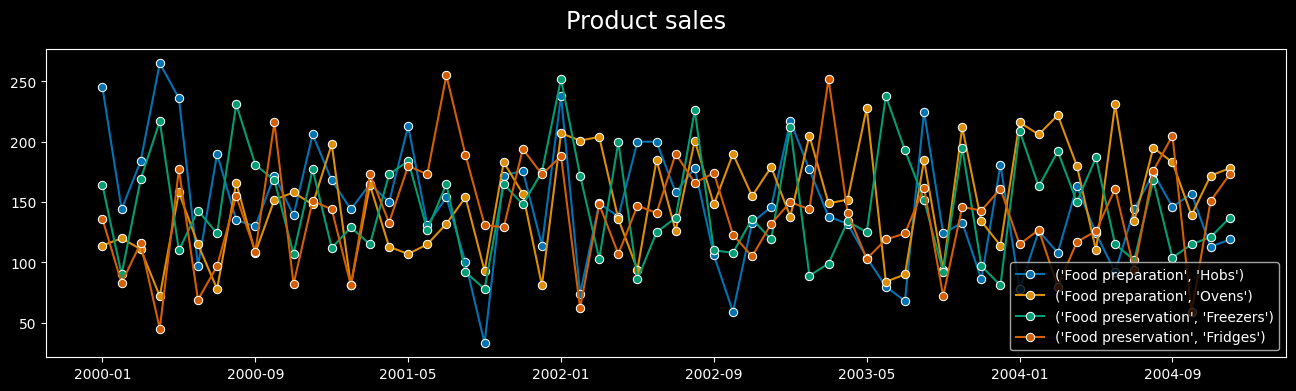

In [32]:
product_index = y.droplevel(-1).index.unique()
fig, ax = plot_series(
    *(y.loc[idx] for idx in product_index), labels=product_index, title="Product sales"
)

Forecasting this data simultaneously is easy as `sktime` automatically vectorizes/"up-casts" the models to hierarchical data.

In [33]:
from sktime.forecasting.ets import AutoETS

forecaster = AutoETS(auto=True)

y_pred = forecaster.fit_predict(y_train, fh=[1, 2, 3, 4])
y_pred

Sales
Product line      Product group Date               
Food preparation  Hobs          2004-09  121.444964
                                2004-10  120.502170
                                2004-11  119.559377
                                2004-12  118.616583
                  Ovens         2004-09  182.823610
                                2004-10  183.980932
                                2004-11  185.138253
                                2004-12  186.295575
Food preservation Freezers      2004-09  148.411369
                                2004-10  148.411369
                                2004-11  148.411369
                                2004-12  148.411369
                  Fridges       2004-09  139.052209
                                2004-10  139.052209
                                2004-11  139.052209
                                2004-12  139.052209

In [34]:
forecaster.forecasters_

forecasters
Food preparation  Hobs      AutoETS(auto=True)
                  Ovens     AutoETS(auto=True)
Food preservation Freezers  AutoETS(auto=True)
                  Fridges   AutoETS(auto=True)

Error metrics all apply to hierarchical forecasts by aggregation via mean:

smape = MeanAbsolutePercentageError(symmetric=True)
smape(y_test, y_pred)

Metrics can also be computed by level, setting `multilevel="raw_values"`:

In [35]:
hier_smape = MeanAbsolutePercentageError(symmetric=True, multilevel="raw_values")
errors_local = hier_smape(y_test, y_pred)
errors_local

MeanAbsolutePercentageError
Food preparation  Hobs                         0.126577
                  Ovens                        0.099655
Food preservation Freezers                     0.222258
                  Fridges                      0.372929

More hierarchical forecasting features not shown here:

* hierarchical reconciliation - `ReconcilerForecaster`, `Reconciler`, `Aggregator`
* global models via `make_reduction` and the `pooling` argument
* using different forecasters per level/node, `ForecastByLevel`

### Recap

Quick recap of what we have covered in this notebook:

- Univariate forecasting (stats and ML)
- Univariate with exogenous data
- Multivariate forecasting
- Probabilistic forecasting
- Hierarchical forecasting

### Credits: notebook 2 - forecasting

notebook creation: marrov, fkiraly

partly based on:

* same notebook at ODSC and EuroPython 2023 workshops (fkiraly, marrov)
* pydata 2022 Berlin notebooks (fkiraly, danbartl)
* sktime forecasting tutorial (fkiraly, mloning and others)

sktime forecasting module: [many contributors](https://www.sktime.net/en/latest/about/contributors.html)